In [ ]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
from sim_modules.oct_refocus import (
    forward_refocus_filter, isam_resampling_points, isam, RefocusMode
)
from sim_modules.misc import zoom_fft_correct_phase
from sim_modules.pupils import AberratedPupil3D, PupilType
from sim_modules.aperture import Aperture, IMG_MODE
from sim_modules.plottings import (
    plot_axial_psf,
    plot_x_psfs,
    plot_y_psfs,
    plot_z_psfs,
    plot_psf_xl,
    plot_psf_yl,
    plot_psf_xy,
    plot_psf_xl_reim,
    plot_psf_yl_reim,
    plot_psf_xy_reim,
    plot_psf_xy_3d,
    plot_psfs_power,
    plot_psfs_xl,
    plot_psfs_yl,
    PSFDict,
    OCT_SPECT_AMP_LABEL,
    oct_htilde_unit,
    HORIZONTAL_FREQ_LABEL,
    VERTICAL_FREQ_LABEL,
    HORIZONTAL_COS_LABEL,
    OPL_LABEL,
    plot_2Dpupil,
    plot_3Dpupil,
    plot_wavefronterror
)

In [ ]:
plt.rcParams['text.usetex'] = True

In [ ]:
# Transpose PSF plots or not.
# If True, axial direction is vertical, otherwise horizontal.
TRANSPOSE = True

In [ ]:
# Imaging mode
img_mode = IMG_MODE.PSFD
# img_mode = IMG_MODE.LF
# img_mode = IMG_MODE.SCFF

In [ ]:
# Refractive index of the surrounding medium
# nb = 1.0  # Refractive index of air
nb = 1.34  # Refractive index of tissue

In [ ]:
# Flag normalization of pupils
NORMALIZE = True
# NORMALIZE = False

In [ ]:
# Flag paraxial propagation
PARAXIAL = False  # Simulation with paraxial propagation

In [ ]:
# Spectral dimension

k_num = 301
k = np.linspace(
    2 * np.pi / 1.26,
    2 * np.pi / 0.90,
    num=k_num,
    dtype=np.float32
)  # Wavenumber in air [μm^-1]
kc = (k[-1] + k[0]) / 2
Δk = (k[-1] - k[0]) / 2

c = sp.constants.c * 1e6  # speed of light [μm/s]
dνt = (k[1] - k[0]) / (2 * np.pi) * c

# in tissue
kb = k * nb
kbc = kc * nb
Δkb = Δk * nb

# Single-path optical path length
l = sp.fft.fftshift(sp.fft.fftfreq(k_num, (kb[1] - kb[0]) / (2 * np.pi))) / 2

print("Central wavelength [μm]: {}".format(2 * np.pi / kc))
print("Axial range [μm]: {}".format((l.max() - l.min()) / nb))
print("Axial res [μm]: {}".format(8/Δkb))
print("FWHM wavelength width [nm]: {}".format(
    2 * np.pi / kc ** 2 * Δk * np.sqrt(np.log(2) / 2) * 1e3
))

Central wavelength [μm]: 1.0500000185924125
Axial range [μm]: 262.29084279997795
Axial res [μm]: 5.986126800789171
FWHM wavelength width [nm]: 103.02337058487136


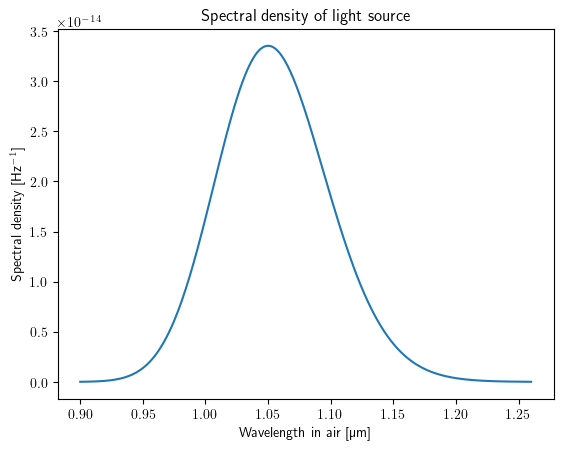

In [ ]:
# Spectral density
s_k = np.exp(- 8 * (kb - kbc) ** 2 / (Δkb ** 2))

if NORMALIZE:
    s_k /= (np.sum(s_k) * dνt)  # [Hz^-1]

plt.figure()
plt.plot(2 * np.pi / k, s_k)
plt.title("Spectral density of light source")
plt.xlabel("Wavelength in air [µm]")
plt.ylabel("Spectral density " + "[Hz$^{-1}$]" if NORMALIZE else "[a.u.]")
plt.show()

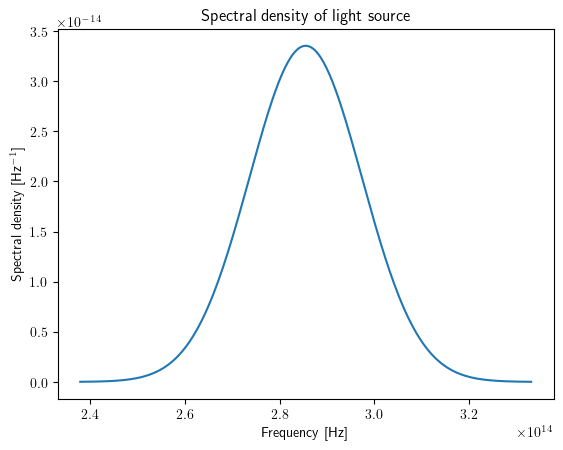

In [ ]:
plt.figure()
plt.plot(c * k / (2 * np.pi), s_k)
plt.title("Spectral density of light source")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Spectral density " + "[Hz$^{-1}$]" if NORMALIZE else "[a.u.]")
plt.show()

In [ ]:
# Wavefront aberration parameters
# NOTE: The wavefront aberration simulation is now available
# for the same cut-off NA and the shared optical path
# between the illumination and collection.
#
# In the case of the shared path but the different cut-off NA,
# scaling of Zernike expansion will be used.
# - Jim Schwiegerling, "Scaling Zernike expansion coefficients to different pupil sizes," J. Opt. Soc. Am. A 19, 1937-1945 (2002)
#
# In the case of the different optical path, the wavefront aberration
# coefficients should be defined separately.

ns = [(2, 2), (3, 1), (4, 0)]  # Zernike expansion orders
coeff = [(0.0, 0.0), (0.0, 0.0), 0.0]  # Zernike expansion coefficients (RMS) [µm]

In [ ]:
# Calculate RMS wavefront error
rms = 0
for cos in coeff:
    for co in (cos if isinstance(cos, tuple) else (cos,)):
        rms += co ** 2
rms = np.sqrt(rms)
print("RMS wavefront error [µm]: {}".format(rms))

RMS wavefront error [µm]: 0.0


In [ ]:
# Chromatic aberrations
Δx = 0.0  # Transversal focal shift amount per bandwidth [µm]
Δz = 0.0  # Longitudinal focal shift amount per bandwidth [µm]

ca = (Δx / Δkb, 0, Δz / Δkb)

In [ ]:
# Size parameters of pupil, NA in air
if img_mode == IMG_MODE.SCFF:
    na_co_ill = 0.0
    na_w_ill = 0.0
    pupil_ill = None
else:
    pupil_ill = AberratedPupil3D(PupilType.GAUSS, 0.25, ns, coeff, na_w=0.15, ca=ca, kc=kbc)
    # pupil_ill = AberratedPupil3D(PupilType.HANN, 0.25, ns, coeff, ca=ca, kc=kbc)
    # pupil_ill = AberratedPupil3D(PupilType.BESSEL, 0.25, ns, coeff, ca=ca, kc=kbc, w=0.01)

pupil_col = AberratedPupil3D(PupilType.GAUSS, 0.25, ns, coeff, na_w=0.15, ca=ca, kc=kbc)
# pupil_col = AberratedPupil3D(PupilType.HANN, 0.25, ns, coeff, ca=ca, kc=kbc)

In [ ]:
# Pupil coordinates
νpx_num = 257
# νpx_num = 501

if img_mode == IMG_MODE.SCFF:
    na_co_ill_max = 0.0
else:
    if np.isscalar(pupil_ill.na_co):
        na_co_ill_max = pupil_ill.na_co
    else:
        na_co_ill_max = max(pupil_ill.na_co)

if np.isscalar(pupil_col.na_co):
    na_co_col_max = pupil_col.na_co
else:
    na_co_col_max = max(pupil_col.na_co)

νx_max = (kb.max() / (2 * np.pi)) * max(na_co_ill_max, na_co_col_max)
νpx, νpy = np.meshgrid(
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    np.linspace(start=-νx_max, stop=νx_max, num=νpx_num, dtype=np.float32),
    indexing='xy'
)

dνx = dνy = νpx[0, 1] - νpx[0, 0]

In [ ]:
# Spatial frequency coordinates for the illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        νx_ill = None
        νy_ill = None
    case IMG_MODE.PSFD:
        νx_ill = νpx
        νy_ill = νpy
    case IMG_MODE.LF:
        νx_ill = νpx[None, 0]
        νy_ill = np.zeros_like(νx_ill)

In [ ]:
# Pupil coordinates for the central wavelength
if img_mode == IMG_MODE.SCFF:
    pass
else:
    σxc_ill = - 2 * np.pi * νx_ill / kbc
    σyc_ill = - 2 * np.pi * νy_ill / kbc
σxc_col = - 2 * np.pi * νpx / kbc
σyc_col = - 2 * np.pi * νpy / kbc

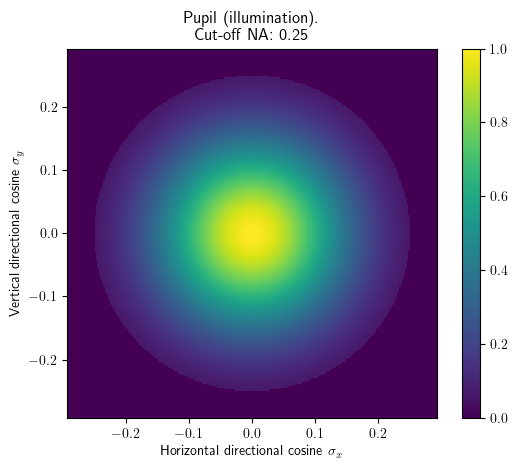

In [ ]:
# 2D plot of the illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        pass
    case IMG_MODE.LF:
        P = pupil_ill.pupil2D(σxc_ill, σyc_ill)
        plt.figure()
        plt.plot(σxc_ill[0], P[0])
        plt.title(
            "Pupil (illumination).\n"
            "Cut-off NA: {}".format(
                pupil_ill.na_co
            )
        )
        plt.xlabel(HORIZONTAL_COS_LABEL)
        plt.show()
    case IMG_MODE.PSFD:
        plot_2Dpupil(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

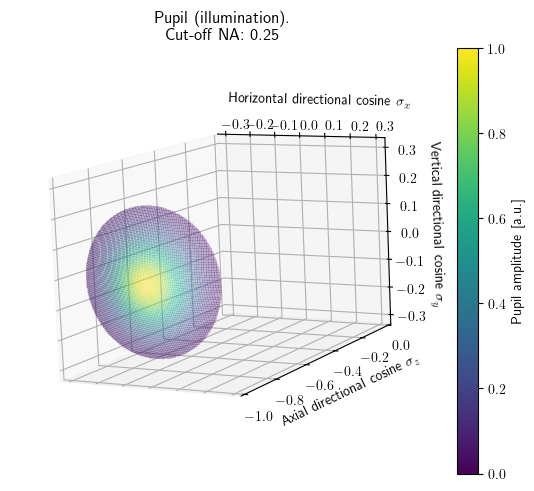

In [ ]:
# 3D surface plot of the illumination pupil
if img_mode == IMG_MODE.PSFD:
    plot_3Dpupil(
        pupil_ill,
        σxc_ill,
        σyc_ill,
        'illumination'
    )

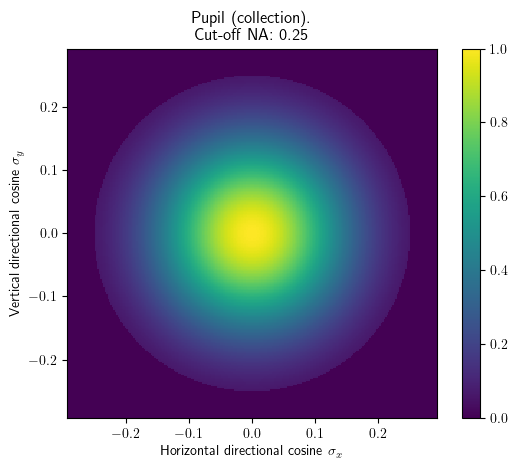

In [ ]:
# 2D plot of the collection pupil

plot_2Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

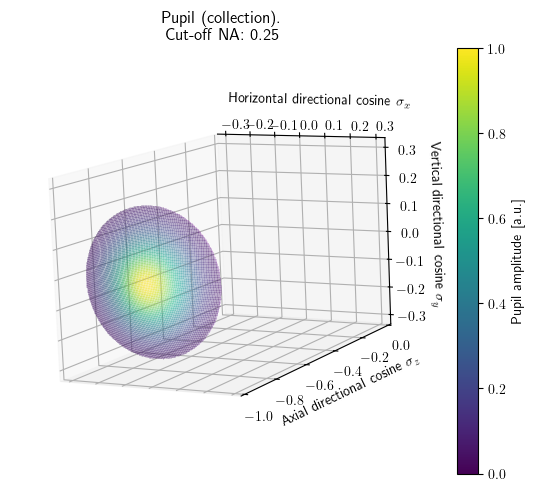

In [ ]:
# 3D surface plot of the collection pupil
plot_3Dpupil(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

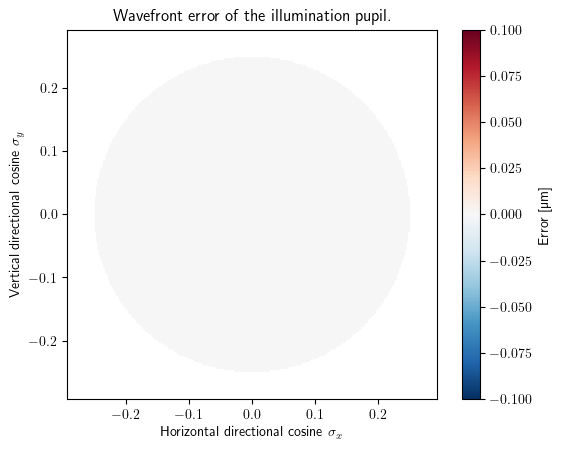

In [ ]:
# 2D plot of wavefront error in illumination pupil
match img_mode:
    case IMG_MODE.SCFF:
        pass
    case IMG_MODE.LF:
        pupil_ill.set_wavefront_error(σxc_ill, σyc_ill)
        W_ill = pupil_ill.we
        plt.figure()
        plt.plot(σxc_ill[0], W_ill[0])
        plt.title("Wavefront error of the illumination pupil.")
        plt.xlabel(HORIZONTAL_COS_LABEL)
        plt.show()
    case IMG_MODE.PSFD:
        plot_wavefronterror(
            pupil_ill,
            σxc_ill,
            σyc_ill,
            'illumination'
        )

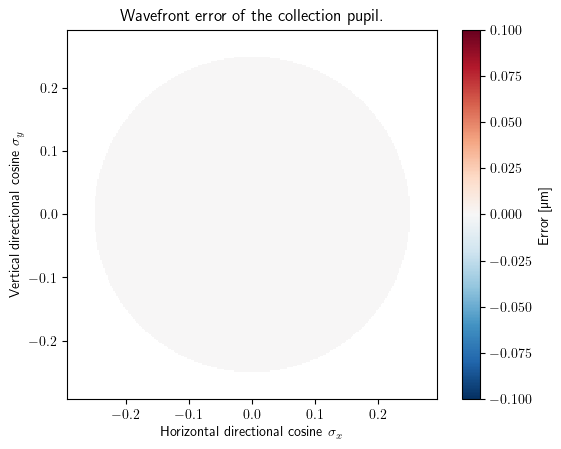

In [ ]:
# 2D plot of wavefront error in collection pupil
plot_wavefronterror(
    pupil_col,
    σxc_col,
    σyc_col,
    'collection'
)

In [ ]:
# Spatial coordinate
match img_mode:
    case IMG_MODE.SCFF:
        νx_num = νpx_num
        νy_num = νpx_num
    case IMG_MODE.PSFD:
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num * 2 - 1  # Doubled to take into account convolution
    case IMG_MODE.LF:
        νx_num = νpx_num * 2 - 1  # Doubled to take into account convolution
        νy_num = νpx_num
    case _:
        raise ValueError("Invalid imaging mode")
y = sp.fft.fftshift(sp.fft.fftfreq(νy_num, (νpy[1, 0] - νpy[0, 0])))
x = sp.fft.fftshift(sp.fft.fftfreq(νx_num, (νpx[0, 1] - νpx[0, 0])))

print(x.max() - x.min())

343.20963915806476


In [ ]:
# Spatial frequency coordinates for the aperture
νx = sp.fft.fftshift(sp.fft.fftfreq(νx_num, 1 / (νx_num * (νpx[0, 1] - νpx[0, 0]))))
νy = sp.fft.fftshift(sp.fft.fftfreq(νy_num, 1 / (νy_num * (νpy[1, 0] - νpy[0, 0]))))

ν_xx, ν_yy = np.meshgrid(
    νx, νy,
    indexing='xy'
)

In [ ]:
# Axial location
z0 = 0.0  # Axial position of the focal plane

# Scatterers' locations
zs = np.array([0., 100., 200., -100., -200.], dtype=np.float32)
z = z0 - zs
idx_zs0 = np.where(zs == 0)[0][0]
idx_z0 = np.where((z0 - zs) == 0)[0][0]

In [ ]:
# Initialize

h_tilde = np.zeros((νy_num, νx_num) + z.shape + k.shape, dtype=np.complex64)

ill_amp = np.zeros(k.shape, dtype=np.float32)
col_amp = np.zeros(k.shape, dtype=np.float32)

h_tilde.nbytes / 1024 ** 2

3021.7692947387695

In [ ]:
aperture = Aperture(pupil_ill, pupil_col, img_mode)

In [ ]:
for i, kb_i in enumerate(tqdm(kb)):

    h_tilde[..., i] = aperture(
        (νx_ill, νy_ill),
        (νpx, νpy),
        kb_i, z,
        NORMALIZE, idx_z0=idx_z0, PARAXIAL=PARAXIAL
    )

    if NORMALIZE:
        ill_amp[i] = aperture.ill_amp
        col_amp[i] = aperture.col_amp

  0%|          | 0/301 [00:00<?, ?it/s]

In [ ]:
# Apply phase shift of propagation to the focal plane
h_tilde = h_tilde * np.exp(1j * kb * 2 * z0)[None, None, None, :]

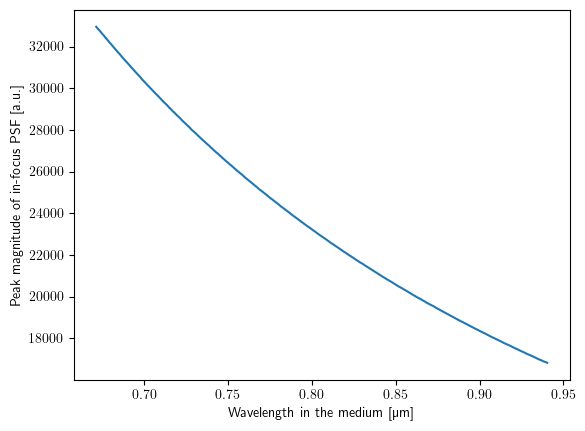

In [ ]:
# Plotting the wavelength-dependent amplitude of h at the center.
if NORMALIZE:
    plt.figure()
    plt.plot((2 * np.pi) / kb, np.abs(np.sum(h_tilde[..., idx_z0, :], axis=(0, 1))))
    plt.xlabel("Wavelength in the medium [µm]")
    plt.ylabel("Peak magnitude of in-focus PSF [a.u.]")
    plt.show()

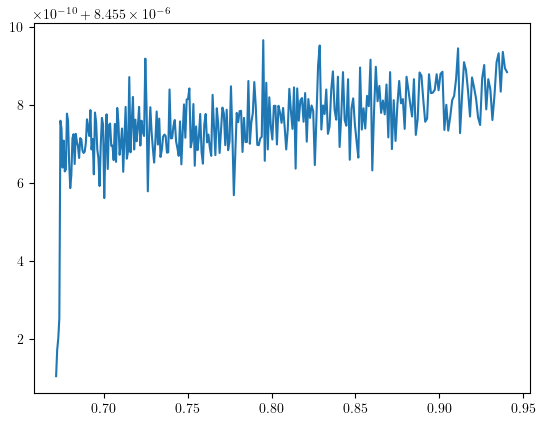

In [ ]:
# normalized peak magnitude of in-focus PSF, should be constant
if NORMALIZE:
    plt.figure()
    plt.plot((2 * np.pi) / kb, np.abs(np.sum(h_tilde[..., idx_z0, :], axis=(0, 1))) / (ill_amp * col_amp))
    plt.show()

In [ ]:
# Fit the peak magnitude of the in-focus PSF with power law
if NORMALIZE:
    ans = np.polyfit(np.log(kb), np.log(np.abs(np.sum(h_tilde[..., idx_z0, :], axis=(0, 1)))), deg=1)
    print("Imaging mode: '{0}', q = {1}".format(img_mode.name, ans[0]))

Imaging mode: 'PSFD', q = 1.9999452462533922


In [ ]:
# Center of gravity of the OCT's spectrum
k_cg = np.sum(s_k * (kb ** 2) * k) / np.sum(s_k * (kb ** 2))

In [ ]:
# Offset of the starting point of the spectrum fron the center of gravity
k_offset = k[0] - k_cg

In [ ]:
# complex point-spread function
# FFT k -> z

SF_MODE = 'PSF'
# SF_MODE = 'LSF'

x12 = [-40.0, 40.0]
xd_num = 129

lw = 20.0 * 2
ld_num = 65

psf = np.zeros((xd_num, xd_num, z.size, ld_num), dtype=np.complex64)
h_tilde_OCT = np.zeros((νy_num, νx_num, z.size, ld_num), dtype=np.complex64)
xd = np.linspace(x12[0], x12[1], num=xd_num, endpoint=True)
ld = np.zeros((ld_num, z.size), dtype=np.float32)  # single-trip OPL

for i in trange(z.size):
    l12 = [nb * zs[i] * 2 - lw / 2, nb * zs[i] * 2 + lw / 2]

    ld[..., i] = np.linspace(l12[0], l12[1], num=ld_num, endpoint=True) / 2

    h_tilde_OCT[..., i, :] = zoom_fft_correct_phase(
            (s_k * (kb ** 2) / (4 * np.pi))[None, None, :]
            * h_tilde[..., i, :],
            l12,
            k_offset / (2 * np.pi),
            fs=(2 * np.pi)/(k[1] - k[0]),
            m=ld_num,
            axis=-1
        ) * dνt

    if SF_MODE == 'PSF':
        psf[..., i, :] = zoom_fft_correct_phase(
            zoom_fft_correct_phase(
                h_tilde_OCT[..., i, :], x12, νx[0],
                fs=1/dνx, m=xd_num, axis=1
            ) * dνx,
            x12, νy[0],
            fs=1/dνy, m=xd_num, axis=0
        ) * dνy
    elif SF_MODE == 'LSF':
        # Layer-spread function
        # This corresponds to the common axial PSF measurements in OCT.
        # The sample is assumed to be a reflective plane, such as a mirror.
        psf[..., i, :] = zoom_fft_correct_phase(
            zoom_fft_correct_phase(
                h_tilde_OCT[νy_num // 2, νx_num // 2, None, None, i, :],
                x12, νx[0],
                fs=1/dνx, m=xd_num, axis=1
            ) * dνx,
            x12, νy[0],
            fs=1/dνy, m=xd_num, axis=0
        ) * dνy

psf_dict: PSFDict = {
    'psf': psf, 'x': xd, 'defocus': -z, 'opl': ld, 'nb': nb,
    'desc': 'Raw', 'MODE': img_mode, 'NORMALIZE': NORMALIZE
}

  0%|          | 0/5 [00:00<?, ?it/s]

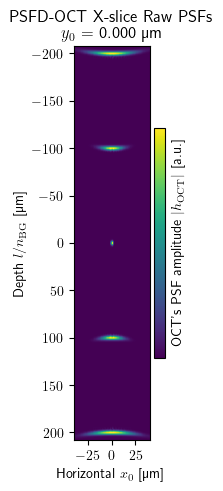

In [ ]:
plot_psfs_xl(psf_dict, TRANSPOSE=TRANSPOSE)

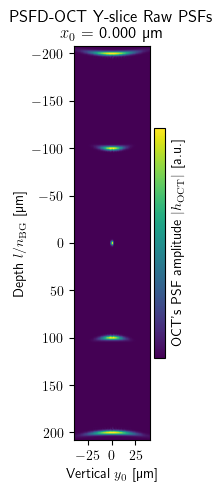

In [ ]:
plot_psfs_yl(psf_dict, TRANSPOSE=TRANSPOSE)

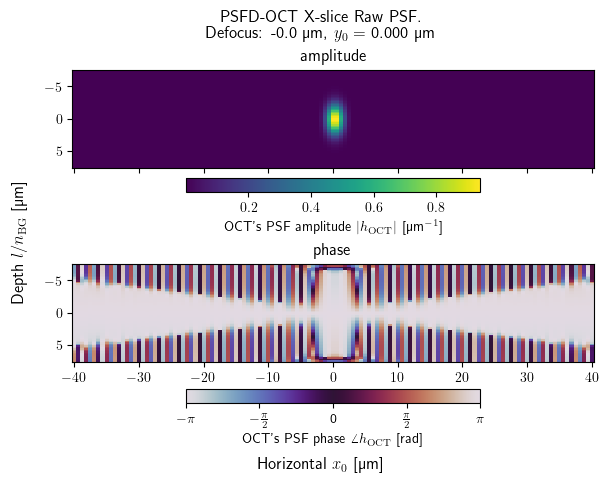

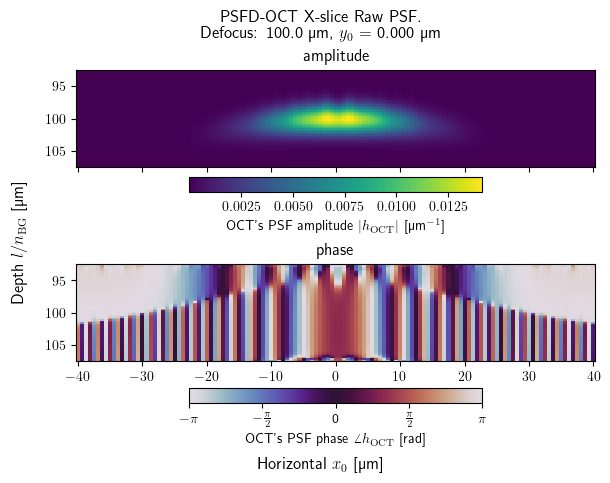

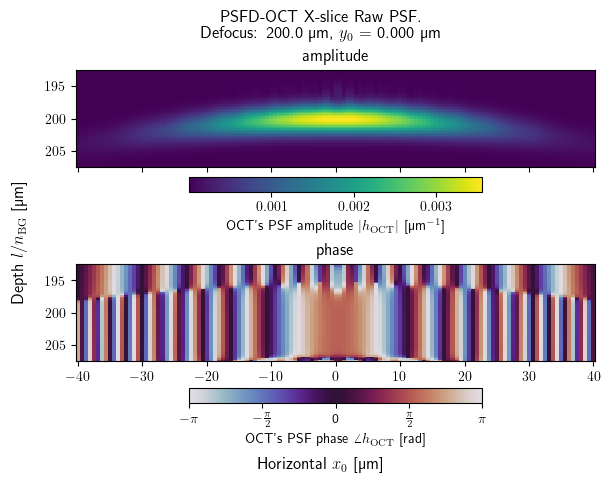

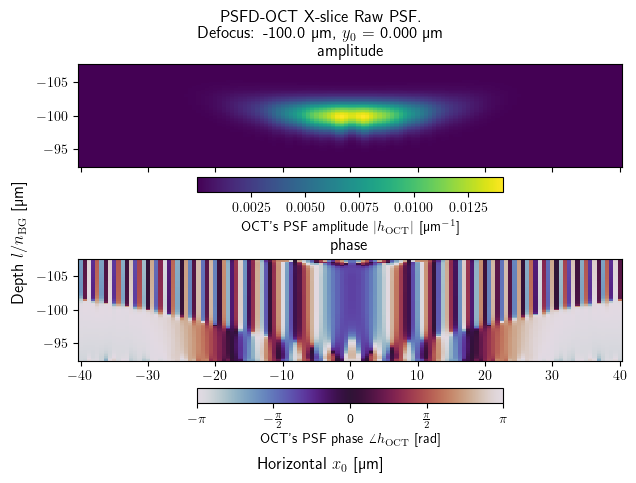

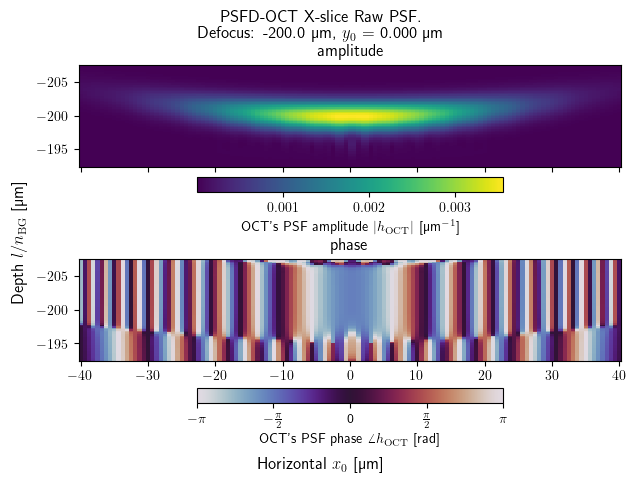

In [ ]:
for i in range(z.size):
    plot_psf_xl(psf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE, cbar_orientation='horizontal')

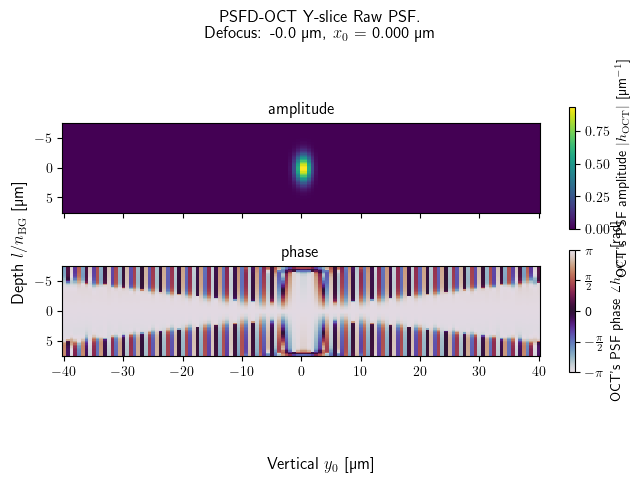

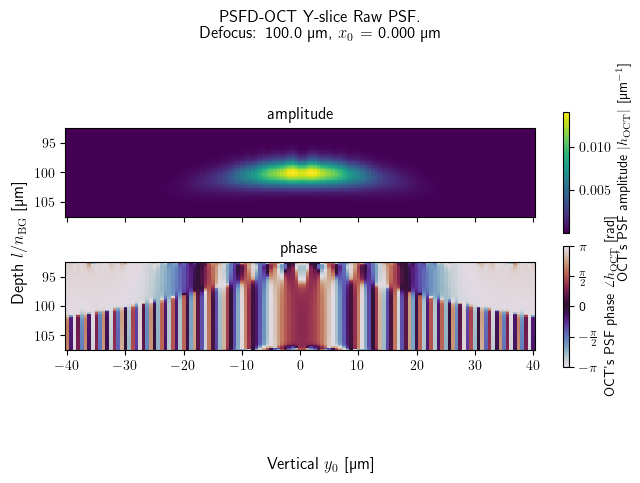

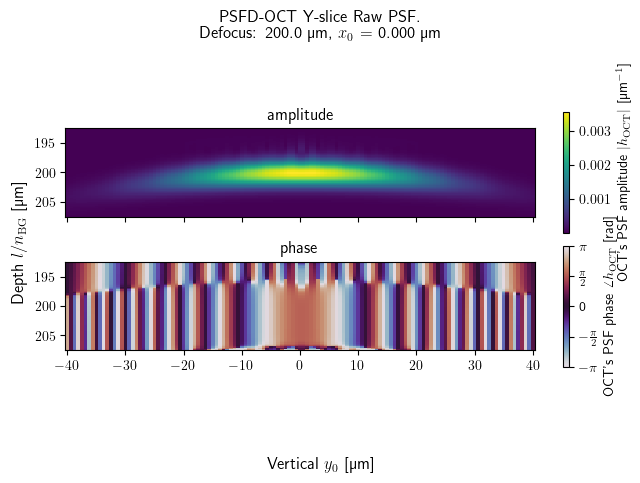

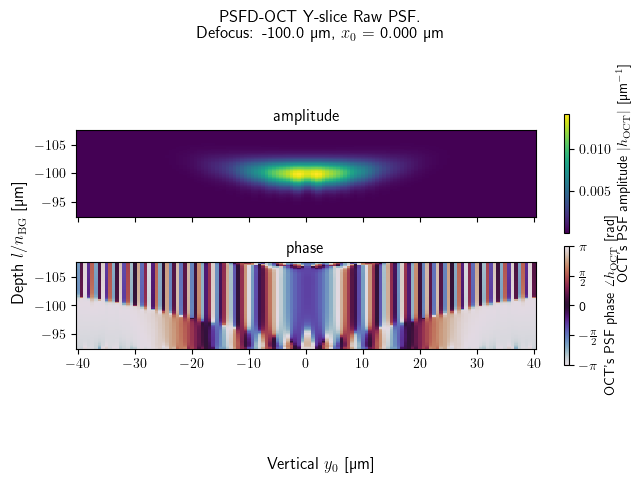

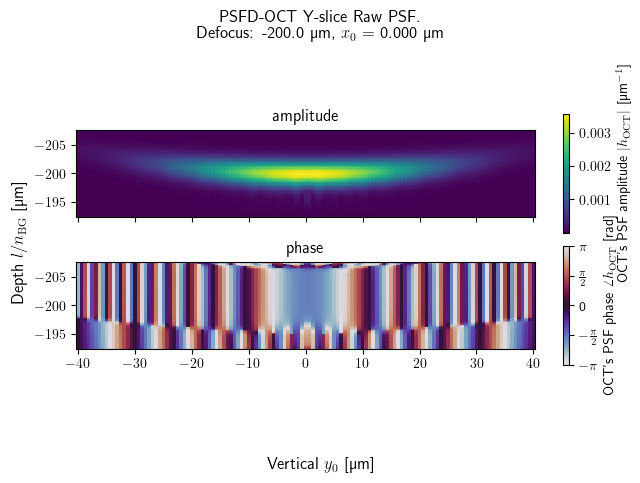

In [ ]:
for i in range(z.size):
    plot_psf_yl(psf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE)

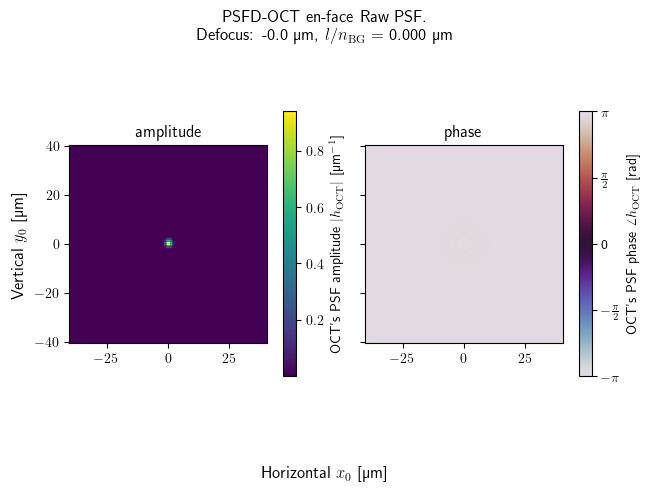

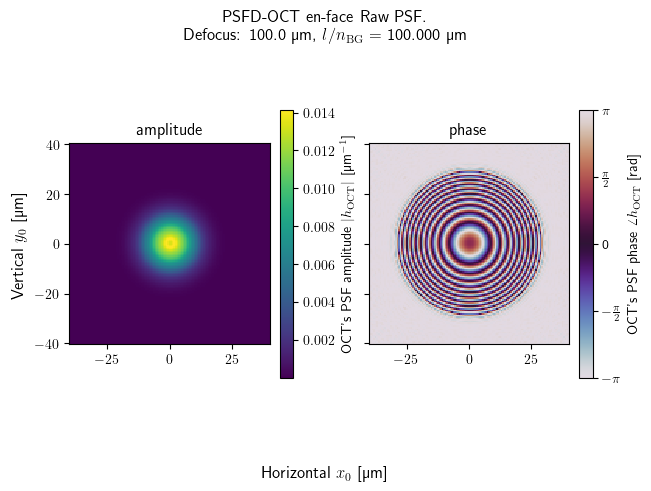

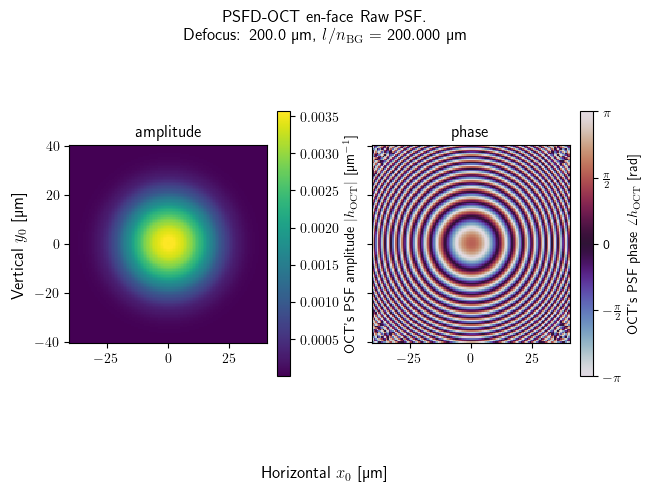

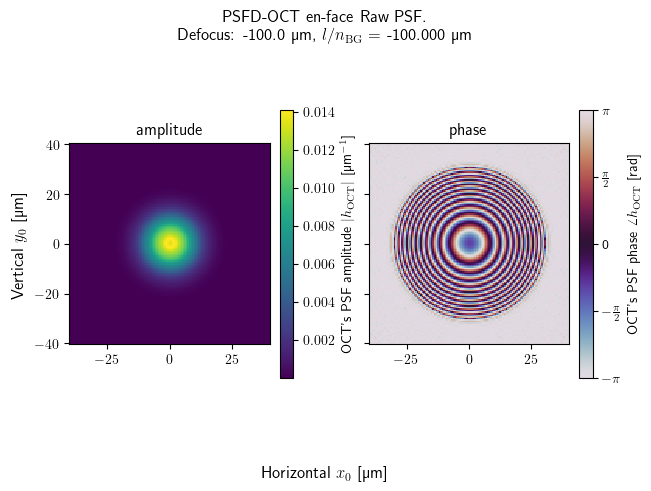

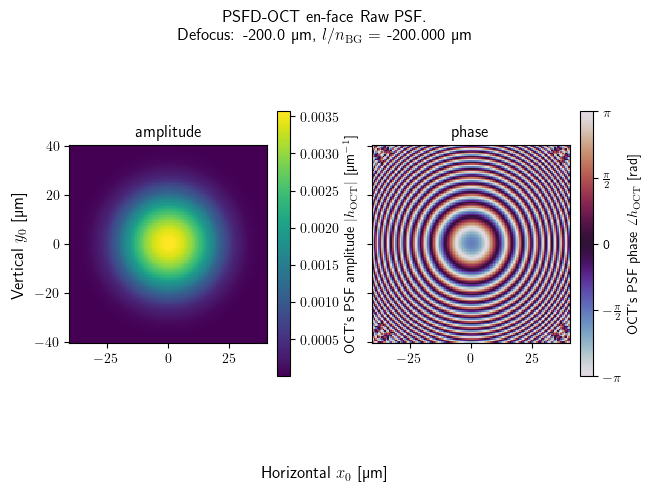

In [ ]:
for i in range(z.size):
    plot_psf_xy(psf_dict, i=i, num=None, l_i_s=0, show_FWHM=False)

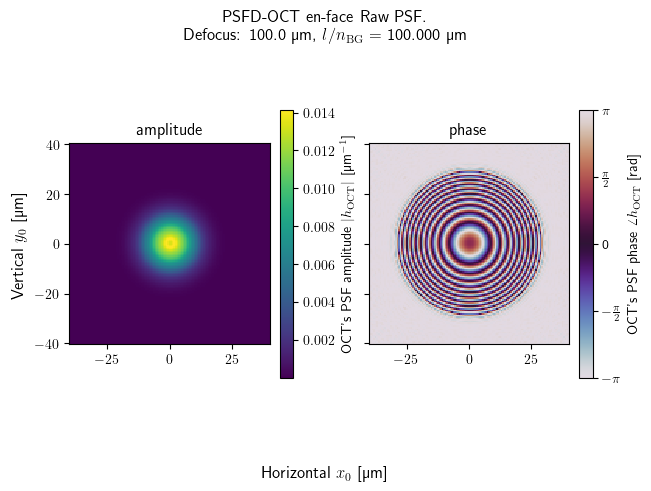

0.014138339

In [ ]:
plot_psf_xy(psf_dict, i=1, num=None, l_i_s=-0, show_FWHM=False)

In [ ]:
# Digital refocusing

In [ ]:
refocus_mode = RefocusMode.PSFO
# refocus_mode = RefocusMode.SCFF
# refocus_mode = RefocusMode.PSPinhole
# refocus_mode = RefocusMode.LF
# refocus_mode = RefocusMode.GaussColLF

In [ ]:
# Refocused PSF
if pupil_ill is not None:
    if pupil_ill.pupil_type == PupilType.GAUSS:
        if np.isscalar(pupil_ill.na_w):
            Df_ill = kbc / (2 * np.pi) * pupil_ill.na_w
        else:
            Df_ill = None
    else:
        Df_ill = None
else:
    Df_ill = None

x_rf12 = [-10.0, 10.0]
y_rf12 = [-10.0, 10.0]
xd_rf_num = 129

psf_rf = np.zeros((xd_rf_num, xd_rf_num, z.size, ld_num), dtype=np.complex64)

xd_rf = np.linspace(x_rf12[0], x_rf12[1], num=xd_rf_num, endpoint=True)

for j in trange(z.size, desc="Decodus"):
    for i, l_i in enumerate(tqdm(ld[:, j], desc="OPL", leave=False)):

        psf_rf[..., j, i] = zoom_fft_correct_phase(
            zoom_fft_correct_phase(
                h_tilde_OCT[..., j, i] *
                forward_refocus_filter(
                    l_i, kbc, nb, z0, (ν_xx, ν_yy), refocus_mode=refocus_mode,
                    Df_ill=Df_ill
                ),
                x_rf12, νx[0],
                fs=1/dνx, m=xd_rf_num, axis=1
            ) * dνx,
            y_rf12, νy[0],
            fs=1/dνy, m=xd_rf_num, axis=0
        ) * dνy

psf_rf_dict: PSFDict = {
    'psf': psf_rf, 'x': xd_rf, 'defocus': -z, 'opl': ld, 'nb': nb,
    'desc': 'Refocused ({})'.format(refocus_mode.name), 'MODE': img_mode,
    'NORMALIZE': NORMALIZE
}

Decodus:   0%|          | 0/5 [00:00<?, ?it/s]

OPL:   0%|          | 0/65 [00:00<?, ?it/s]

OPL:   0%|          | 0/65 [00:00<?, ?it/s]

OPL:   0%|          | 0/65 [00:00<?, ?it/s]

OPL:   0%|          | 0/65 [00:00<?, ?it/s]

OPL:   0%|          | 0/65 [00:00<?, ?it/s]

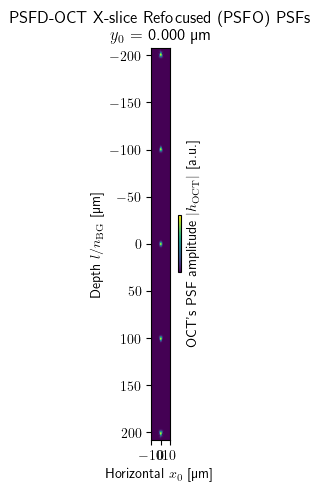

In [ ]:
plot_psfs_xl(psf_rf_dict, TRANSPOSE=TRANSPOSE)

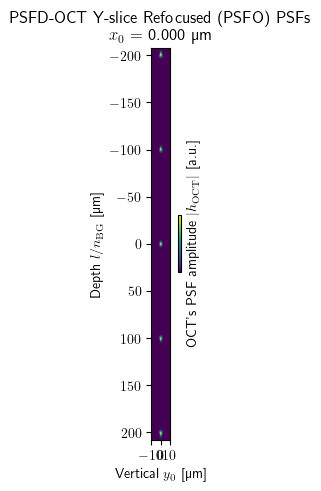

In [ ]:
plot_psfs_yl(psf_rf_dict, TRANSPOSE=TRANSPOSE)

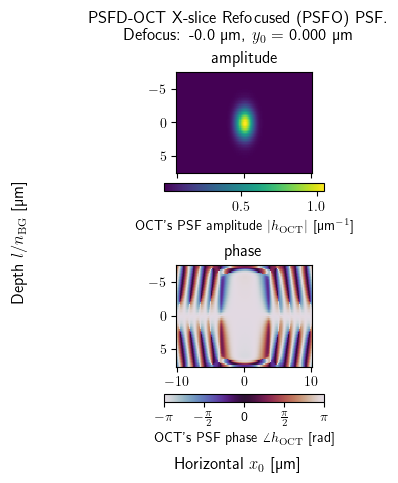

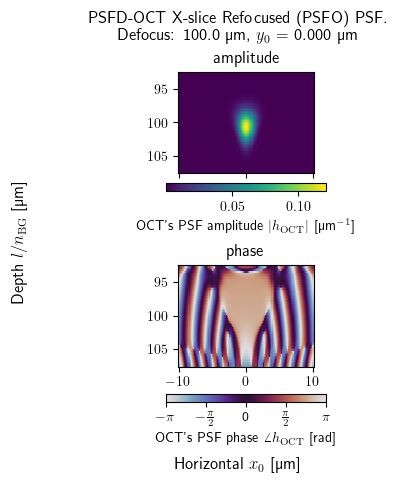

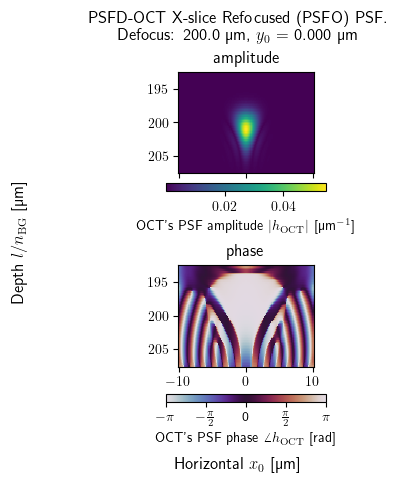

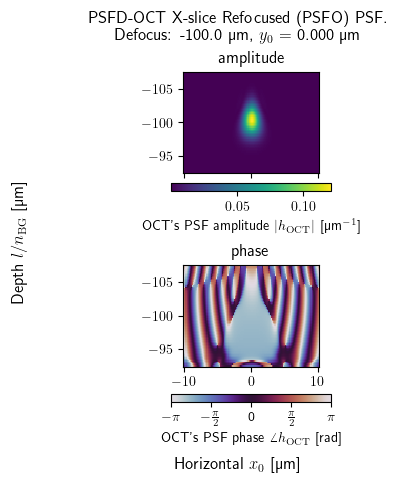

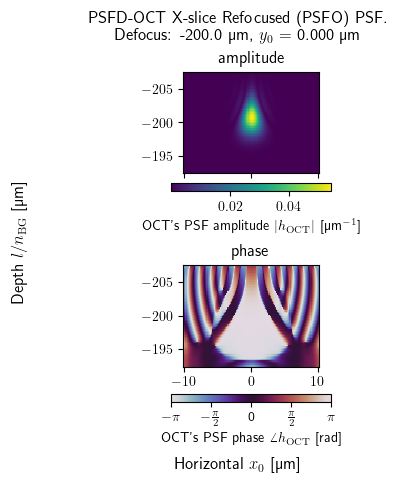

In [ ]:
for i in range(z.size):
    plot_psf_xl(psf_rf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE, cbar_orientation='horizontal')

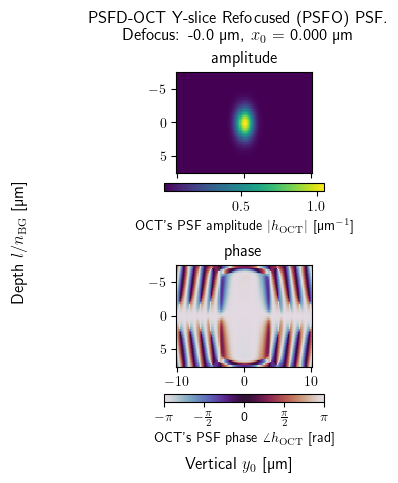

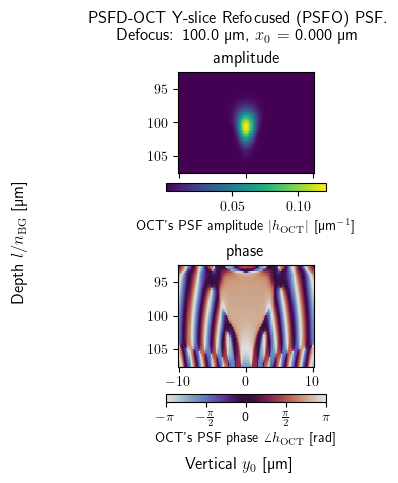

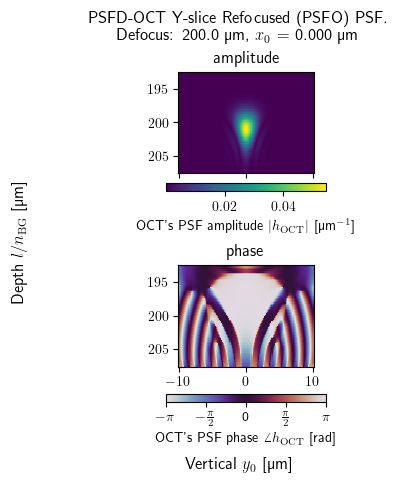

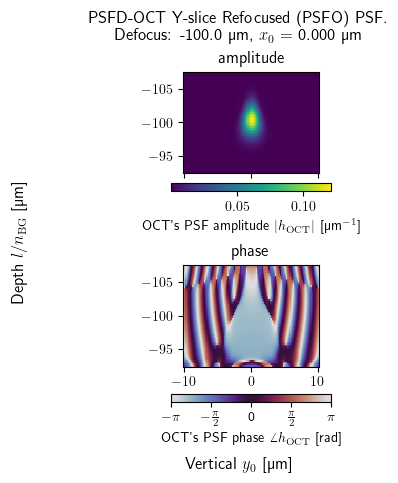

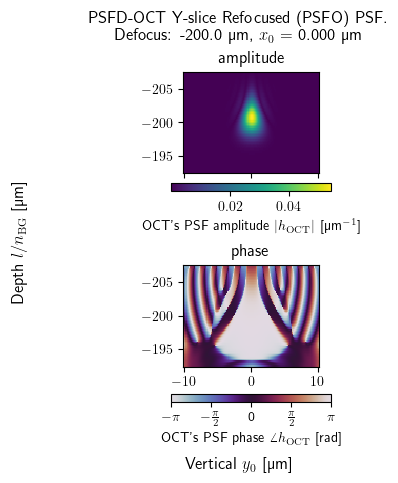

In [ ]:
for i in range(z.size):
    plot_psf_yl(psf_rf_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE, cbar_orientation='horizontal')

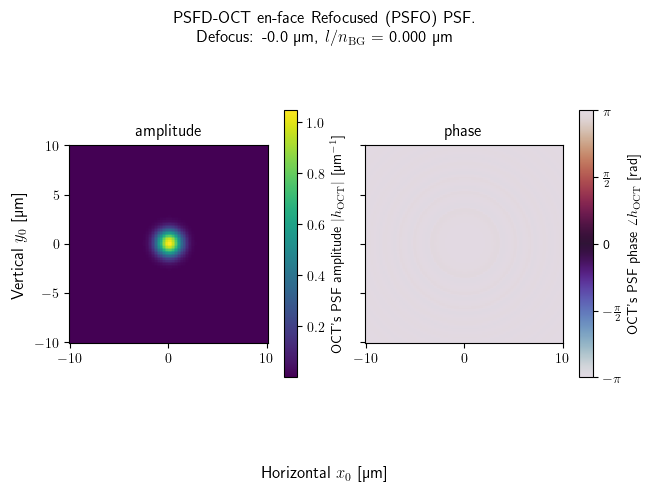

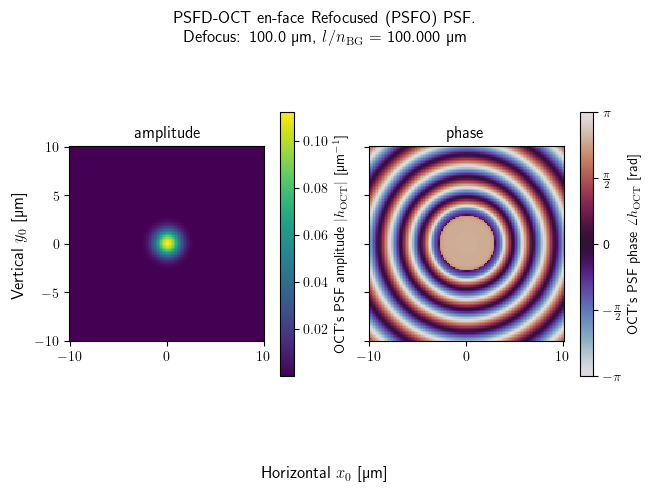

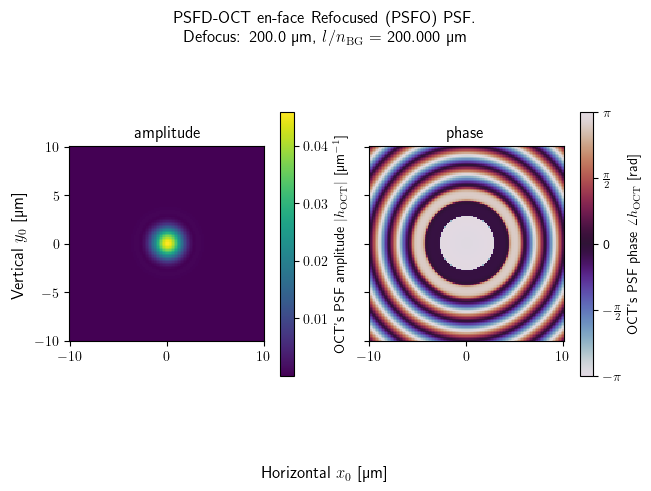

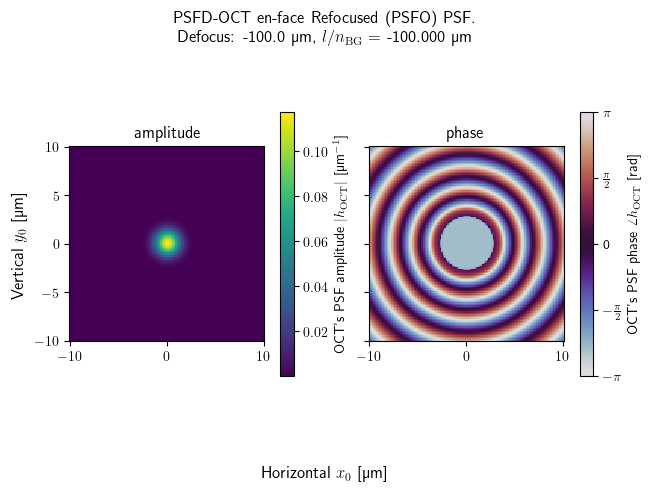

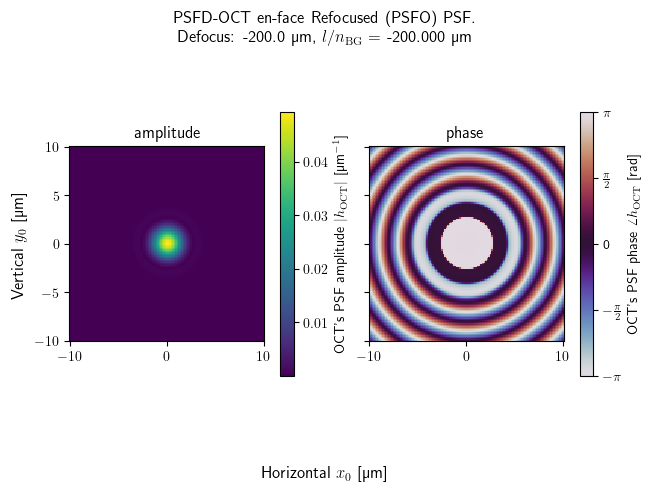

In [ ]:
for i in range(z.size):
    plot_psf_xy(psf_rf_dict, i=i, num=None, l_i_s=-0, show_FWHM=False)

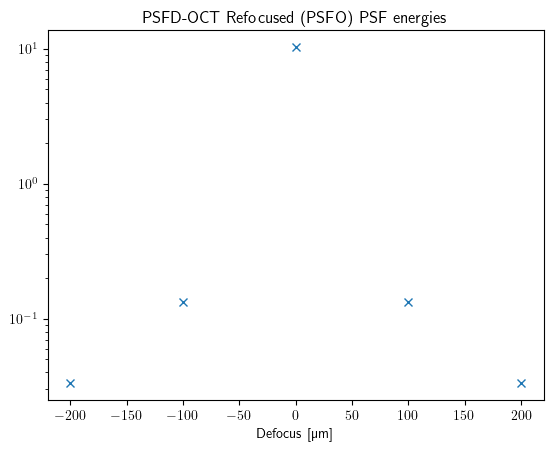

In [ ]:
plot_psfs_power(psf_rf_dict)

In [ ]:
# ISAM (simple)
k_re, νz_re = isam_resampling_points(
    kb, (ν_xx, ν_yy), na_co_ill_max, na_co_col_max,
    refocus_mode=refocus_mode
)

H_ISAM = np.zeros(h_tilde.shape[:-1] + (νz_re.size,), dtype=np.complex64)

for i in trange(H_ISAM.shape[-2]):
    H_ISAM[..., i, :] = isam(
        (s_k * (kb ** 2) / (4 * np.pi))[None, None, :] *
        h_tilde[..., i, :] *
        np.exp(-1j * kb * 2 * z0)[None, None, :],  # Cancel focal shift
        νx, νy, kb, k_re
    ) * np.exp(1j * (2 * np.pi) * νz_re * z0)[None, None, :]  # Revert the axial focal shift

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# Center of gravity of the ISAM's spectrum
s_νz = np.sum(np.abs(H_ISAM), axis=(0, 1, 2))
νz_cg = np.sum(s_νz * νz_re) / np.sum(s_νz)

In [ ]:
# Offset of the starting point of the spectrum fron the center of gravity
νz_offset = νz_re[0] - νz_cg

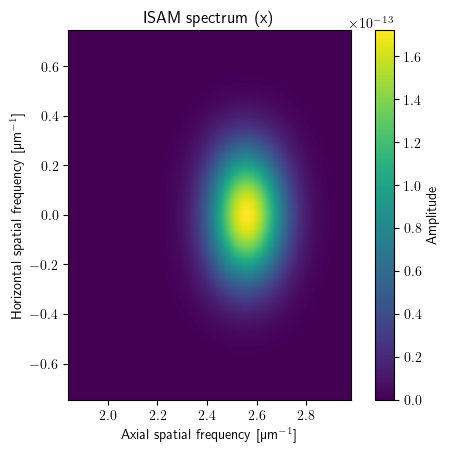

In [ ]:
plt.figure()
plt.pcolormesh(
    νz_re, νx,
    np.abs(H_ISAM[νy_num // 2, :, 0, :])
)
plt.gca().set_aspect('equal')
plt.colorbar(label='Amplitude')
plt.title("ISAM spectrum (x)")
plt.xlabel("Axial spatial frequency [µm$^{-1}$]")
plt.ylabel("Horizontal spatial frequency [µm$^{-1}$]")

plt.show()

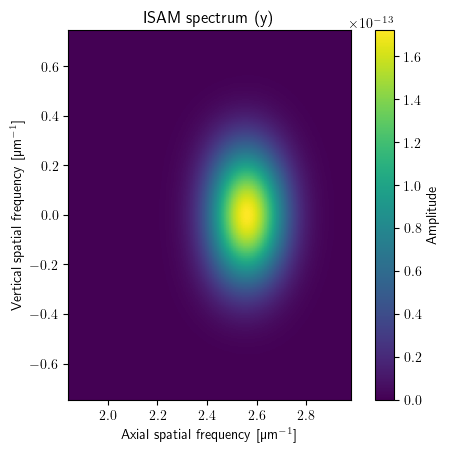

In [ ]:
plt.figure()
plt.pcolormesh(
    νz_re, νy,
    np.abs(H_ISAM[:, νx_num // 2, 0, :])
)
plt.gca().set_aspect('equal')
plt.colorbar(label='Amplitude')
plt.title("ISAM spectrum (y)")
plt.xlabel("Axial spatial frequency [µm$^{-1}$]")
plt.ylabel("Vertical spatial frequency [µm$^{-1}$]")

plt.show()

In [ ]:
# ISAM PSF

x_isam12 = [-10.0, 10.0]
y_isam12 = [-10.0, 10.0]
xd_isam_num = 129

xd_isam = np.linspace(x_isam12[0], x_isam12[1], num=xd_isam_num, endpoint=True)

zw = lw / (2 * nb)
zd_isam_num = 65

psf_isam = np.zeros((xd_isam_num, xd_isam_num, z.size, zd_isam_num), dtype=np.complex64)
zd_isam = np.zeros((zd_isam_num, z.size), dtype=np.float32)

for i in trange(z.size):

    z12 = [zs[i] - zw / 2, zs[i] + zw / 2]
    zd_isam[..., i] = np.linspace(z12[0], z12[1], num=zd_isam_num, endpoint=True)

    psf_isam[..., i, :] = zoom_fft_correct_phase(
        zoom_fft_correct_phase(
            zoom_fft_correct_phase(
                H_ISAM[..., i, :],
                z12,
                νz_offset,
                fs=1/(νz_re[1] - νz_re[0]),
                m=zd_isam_num,
                axis=-1
            ) * (νz_re[1] - νz_re[0]) * c,
            x_isam12, νx[0],
            fs=1/dνx, m=xd_isam_num, axis=1
        ) * dνx,
        y_isam12, νy[0],
        fs=1/dνy, m=xd_isam_num, axis=0
    ) * dνy

psf_isam_dict: PSFDict = {
    'psf': psf_isam, 'x': xd_isam, 'defocus': -z, 'z': zd_isam,
    'desc': 'ISAM ({})'.format(refocus_mode.name), 'MODE': img_mode,
    'NORMALIZE': NORMALIZE
}

  0%|          | 0/5 [00:00<?, ?it/s]

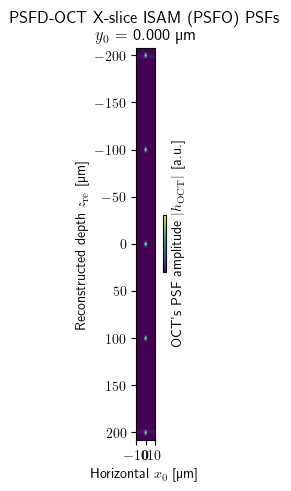

In [ ]:
plot_psfs_xl(psf_isam_dict, TRANSPOSE=TRANSPOSE)

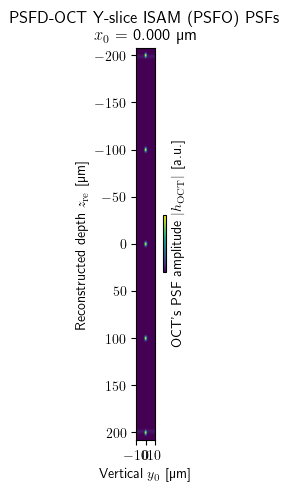

In [ ]:
plot_psfs_yl(psf_isam_dict, TRANSPOSE=TRANSPOSE)

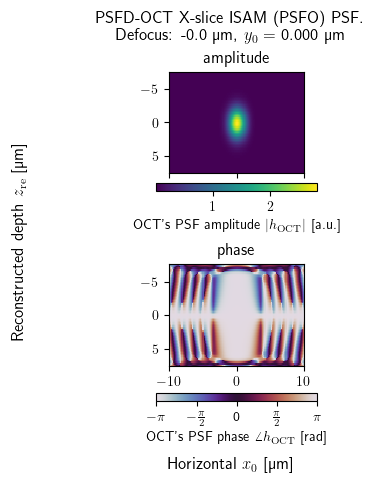

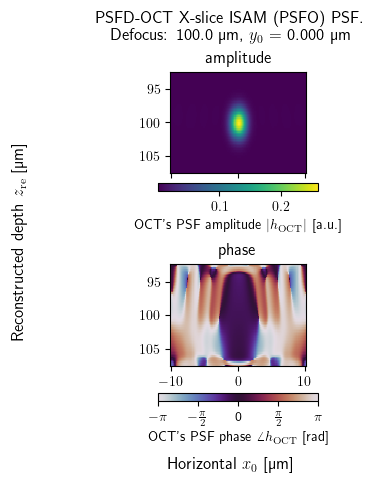

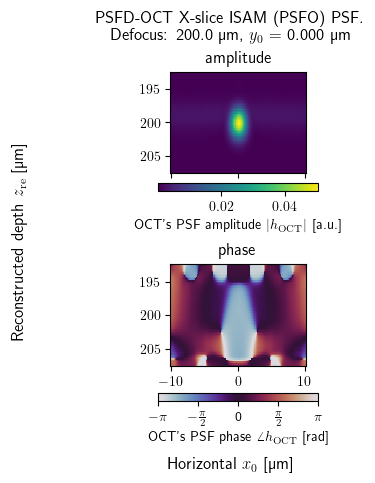

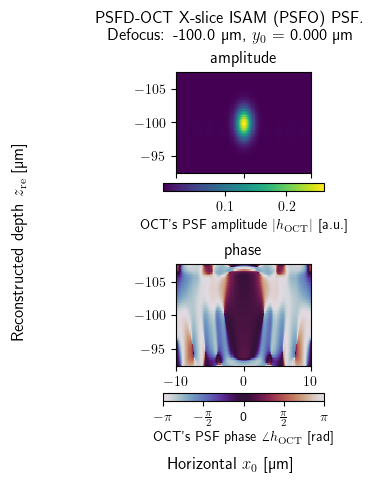

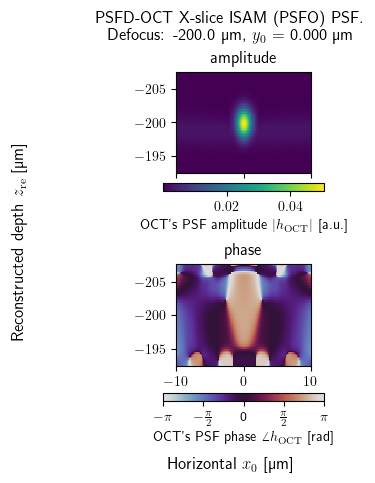

In [ ]:
for i in range(z.size):
    plot_psf_xl(psf_isam_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE, cbar_orientation='horizontal')

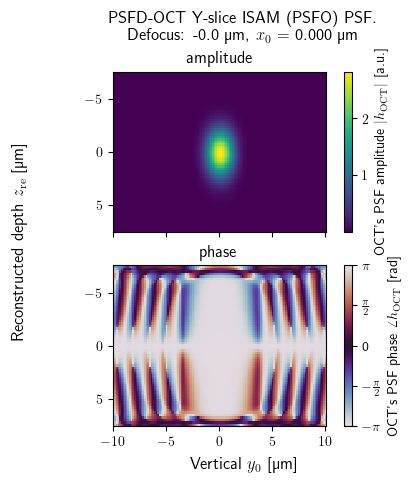

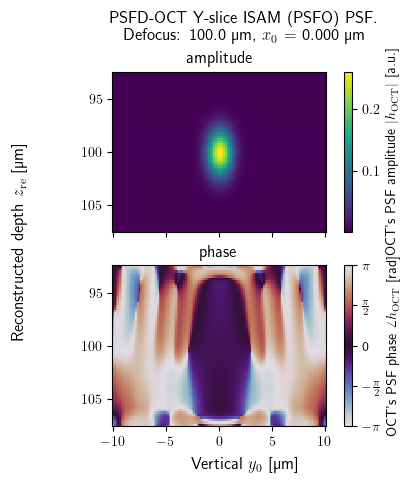

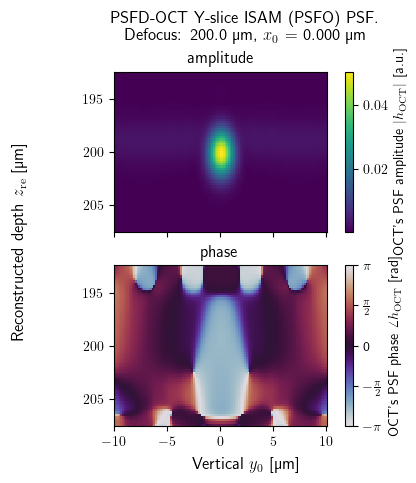

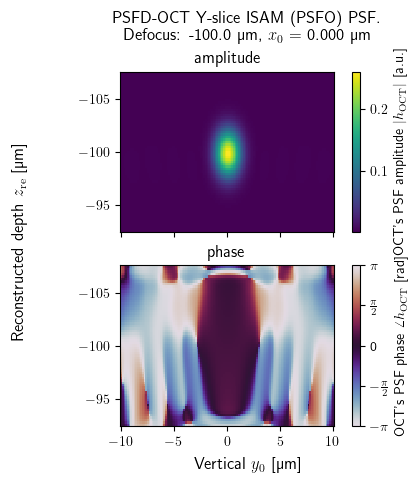

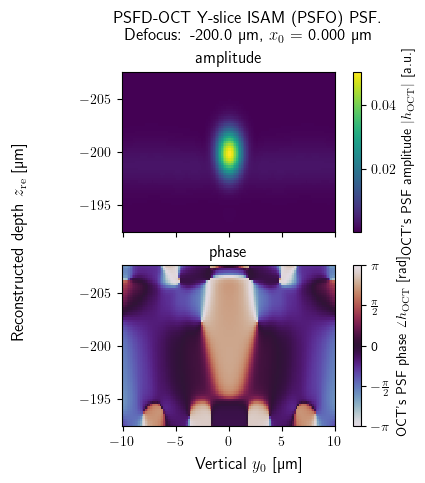

In [ ]:
for i in range(z.size):
    plot_psf_yl(psf_isam_dict, i=i, show_FWHM=False, TRANSPOSE=TRANSPOSE)

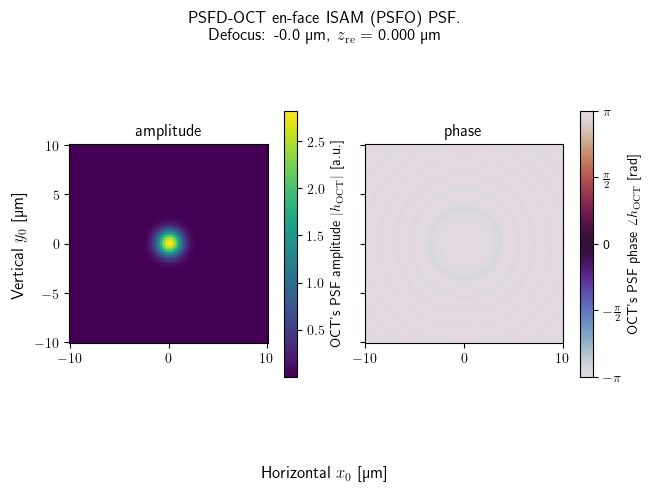

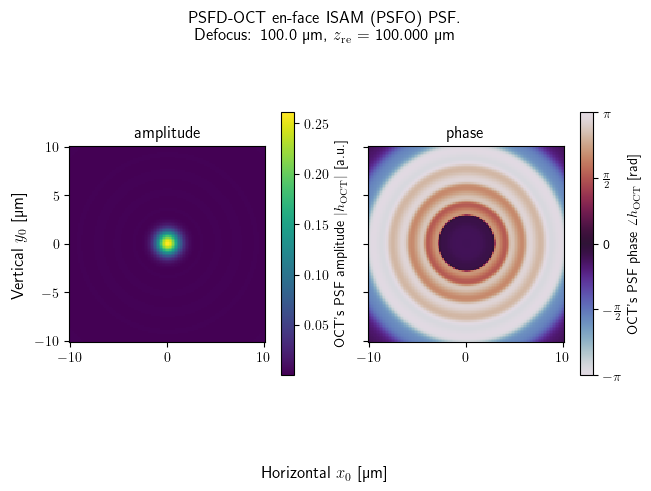

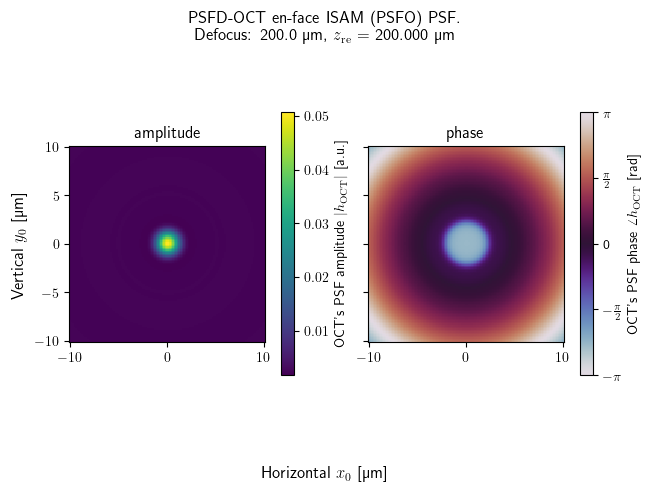

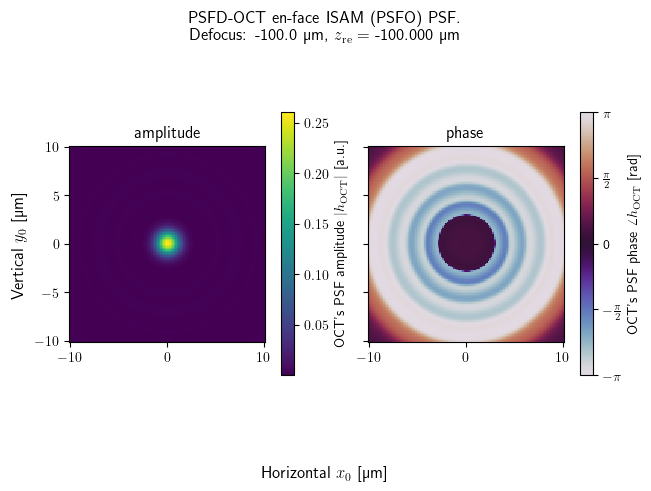

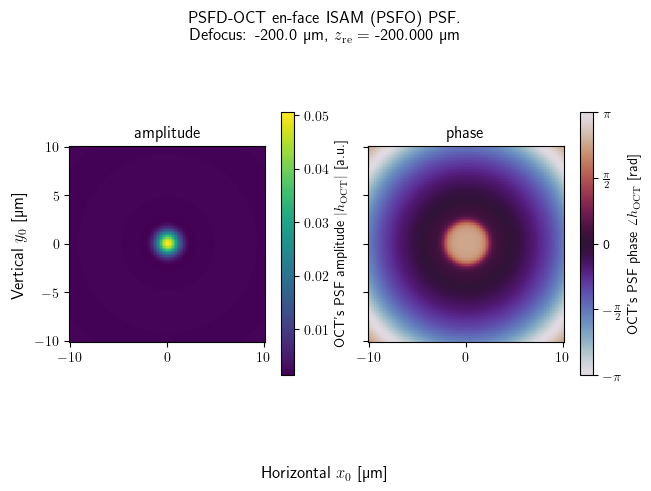

In [ ]:
for i in range(z.size):
    plot_psf_xy(psf_isam_dict, i=i, num=None, l_i_s=0, show_FWHM=False)